Возьмите задачу с винами (https://www.kaggle.com/rajyellow46/wine-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.
! Только для тех у кого уже диплом ! Оформите задачи по дипломной работе в виде этапов CrispDM (например, в trello). Пришлите скриншот.

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина по его физическо-химическому составу

## 1.2 Описание
The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

Attribute Information:

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)

Acknowledgements:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

(https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [1]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# metrics and scores
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# for dirname, _, filenames in os.walk('..\AML_ZAK_HW2'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## 2.2 Вспомогательные функции

In [3]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 2.3 Загрузка данных

In [4]:
df = pd.read_csv("../AML_ZAK_HW2/winequalityN.csv")

## 2.4 Статистика и визуализации

In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

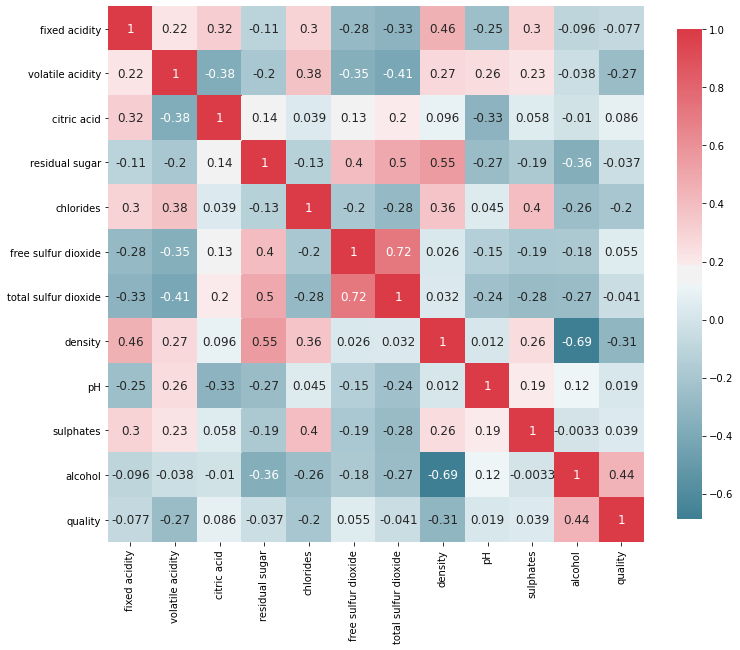

In [8]:
plot_correlation_map( df )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и выживанием пассажира

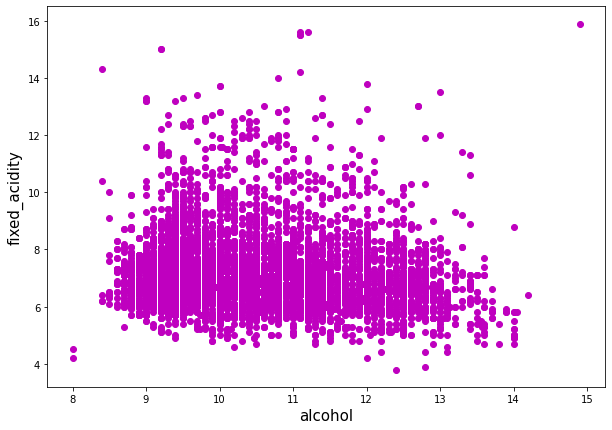

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(x="alcohol",y="fixed acidity",data =df,marker= 'o',c="m")
plt.xlabel("alcohol",fontsize=15)
plt.ylabel("fixed_acidity",fontsize=15)
plt.show()

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


[]

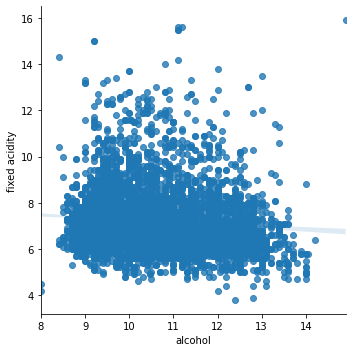

In [10]:
sns.lmplot(x="alcohol",y="fixed acidity",data=df)
plt.plot()

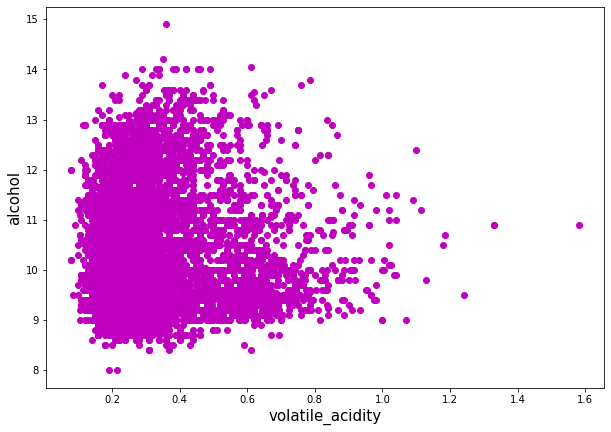

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(x="volatile acidity",y="alcohol",data =df,marker= 'o',c="m")
plt.xlabel("volatile_acidity",fontsize=15)
plt.ylabel("alcohol",fontsize=15)
plt.show()

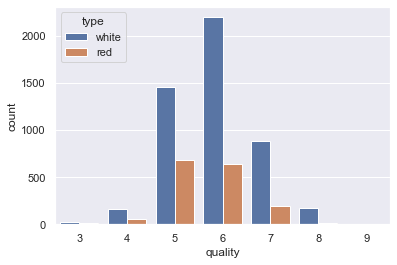

In [12]:
sns.set(style="darkgrid")
sns.countplot(df["quality"],hue="type",data=df)
plt.show()

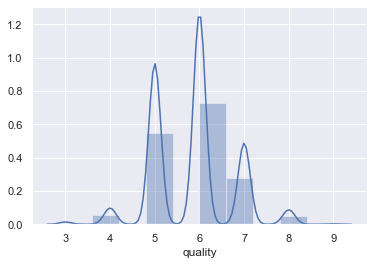

In [13]:
sns.set()
sns.distplot(df["quality"],bins=10)
plt.show()

c:\users\frenzzzzy\appdata\local\programs\python\python38\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


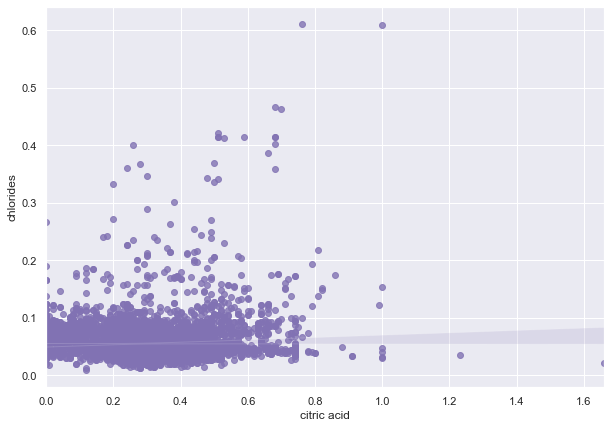

In [14]:
plt.figure(figsize=(10,7))
sns.regplot(x="citric acid",y="chlorides",data =df,marker= 'o',color="m")
plt.show()

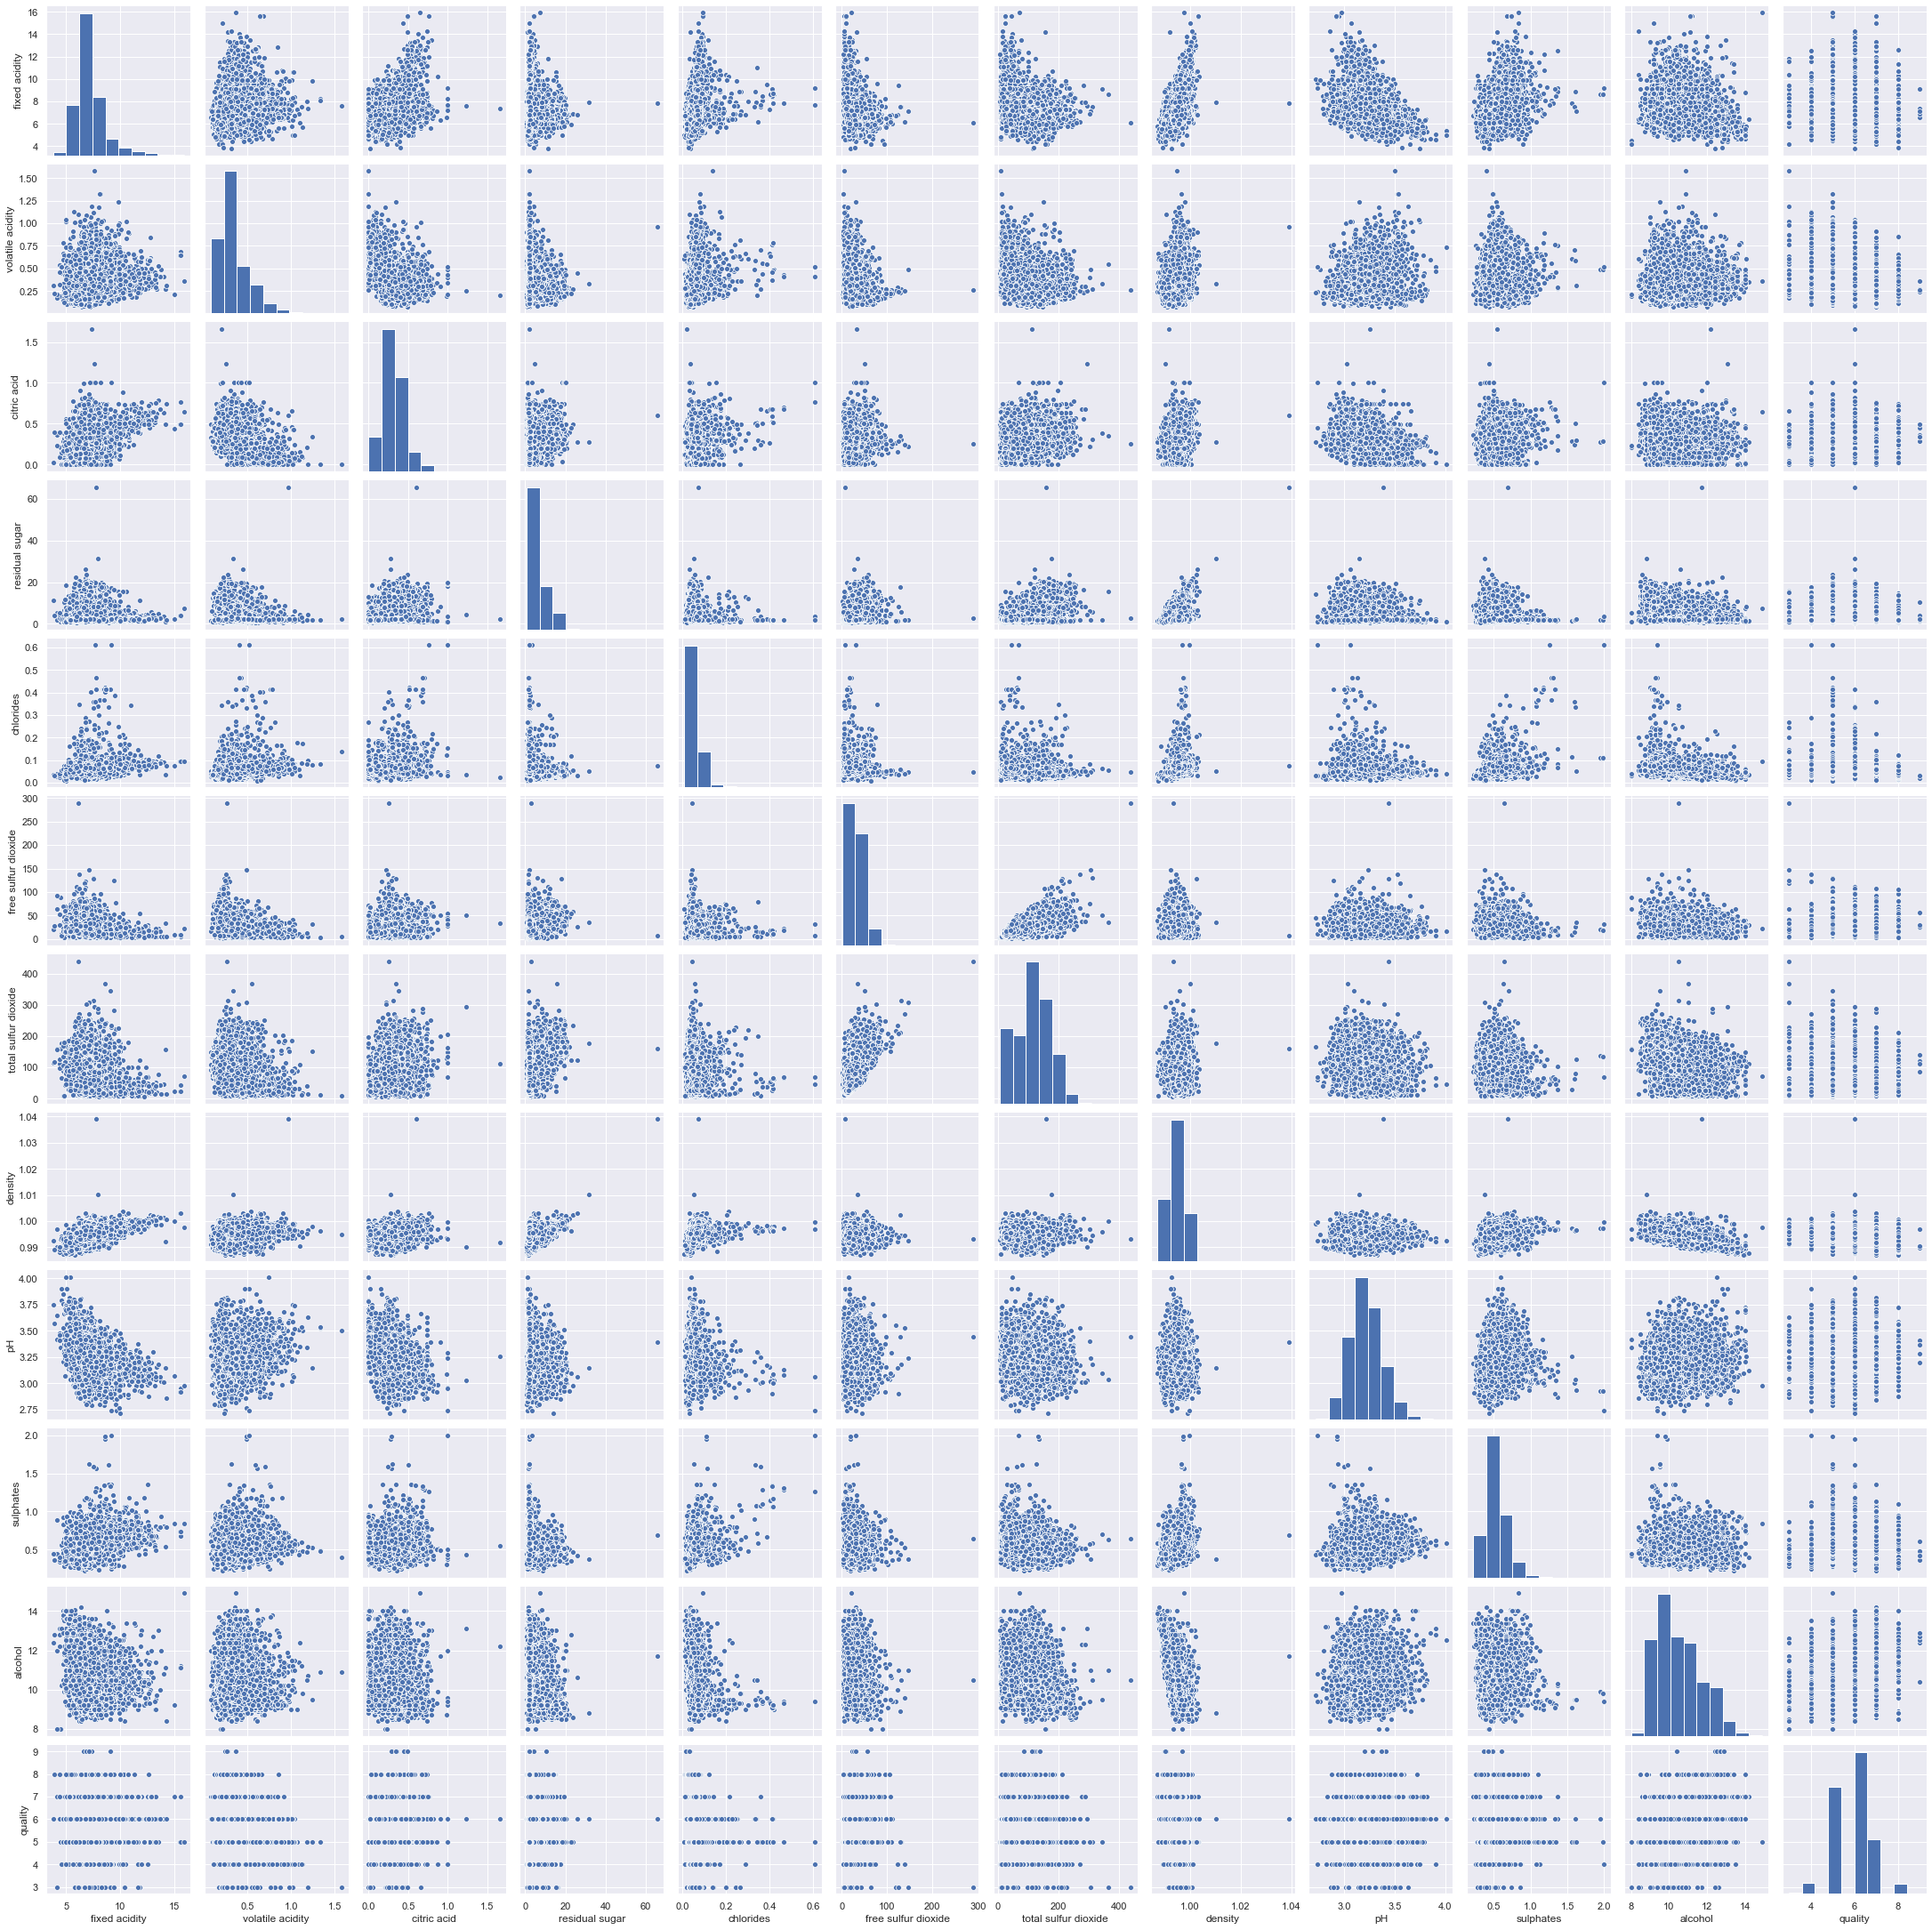

In [15]:
sns.set()
sns.pairplot(df)
plt.show()

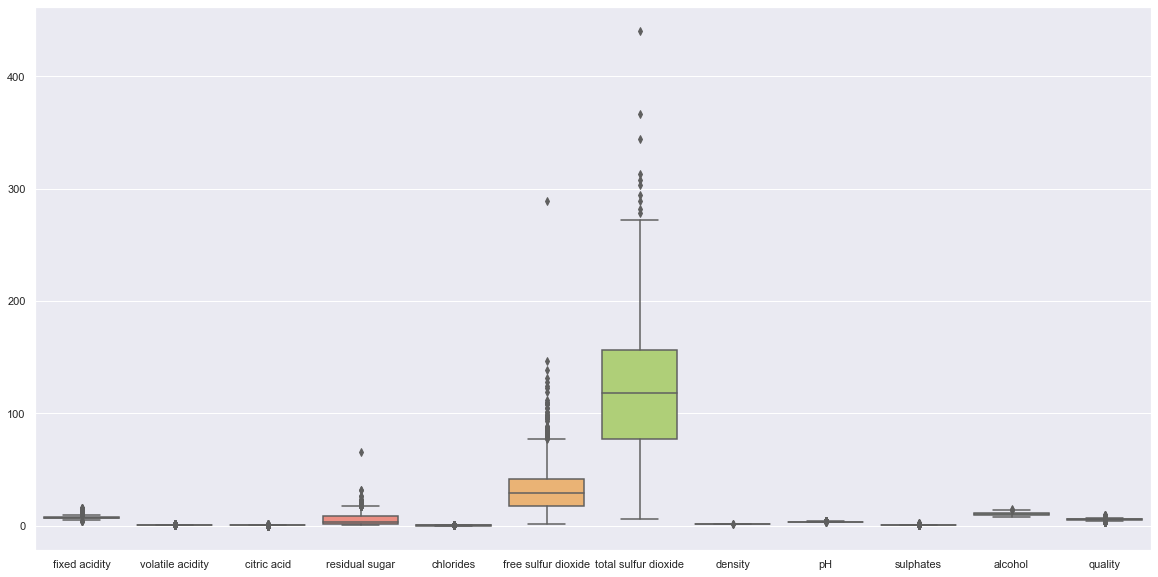

In [16]:
sns.set()
plt.figure(figsize=(20,10))
sns.boxplot(data=df,palette="Set3")
plt.show()

# 3. Data Preparation

## 3.1 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [17]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [18]:
df["fixed acidity"].value_counts()

6.80     354
6.60     326
6.40     305
7.00     282
6.90     279
        ... 
14.30      1
15.90      1
13.80      1
14.20      1
6.45       1
Name: fixed acidity, Length: 106, dtype: int64

In [19]:
mean = df["fixed acidity"].mean()
df["fixed acidity"].fillna(mean,inplace=True)
df["fixed acidity"].isnull().sum()

0

In [20]:
mean2 = df["volatile acidity"].mean()
df["volatile acidity"].fillna(mean,inplace=True)
df["volatile acidity"].isnull().sum()

0

In [21]:
df["citric acid"].value_counts()

0.30    337
0.28    301
0.32    289
0.49    283
0.26    257
       ... 
1.66      1
0.75      1
0.86      1
0.99      1
1.23      1
Name: citric acid, Length: 89, dtype: int64

In [22]:
mean3 = df["citric acid"].mean()
df["citric acid"].fillna(mean,inplace=True)
df["citric acid"].isnull().sum()

0

In [23]:
df["residual sugar"].value_counts()

2.00     235
1.80     228
1.60     223
1.40     219
1.20     195
        ... 
14.15      1
14.05      1
3.15       1
8.95       1
20.30      1
Name: residual sugar, Length: 316, dtype: int64

In [24]:
mean4 = df["residual sugar"].mean()
df["residual sugar"].fillna(mean,inplace=True)
df["residual sugar"].isnull().sum()

0

In [25]:
mean4 = df["chlorides"].mean()
df["chlorides"].fillna(mean,inplace=True)
df["chlorides"].isnull().sum()

0

In [26]:
mean5 = df["pH"].mean()
df["pH"].fillna(mean,inplace=True)
df["pH"].isnull().sum()

0

In [27]:
mean6 = df["sulphates"].mean()
df["sulphates"].fillna(mean,inplace=True)
df["sulphates"].isnull().sum()

0

In [28]:
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 3.2 Обработка выбросов

In [29]:
lower_limit = df["free sulfur dioxide"].mean() - 3*df["free sulfur dioxide"].std()
upper_limit = df["free sulfur dioxide"].mean() + 3*df["free sulfur dioxide"].std()

In [30]:
print(lower_limit,upper_limit)

-22.722879937832957 83.77351869418204


In [31]:
df2 = df[(df["free sulfur dioxide"] > lower_limit) & (df["free sulfur dioxide"] < upper_limit)]

In [32]:
df.shape[0] - df2.shape[0]

36

In [33]:
lower_limit = df2['total sulfur dioxide'].mean() - 3*df2['total sulfur dioxide'].std()
upper_limit = df2['total sulfur dioxide'].mean() + 3*df2['total sulfur dioxide'].std()
print(lower_limit,upper_limit)

-53.15243132839616 283.6543660134294


In [34]:
df3 = df2[(df2['total sulfur dioxide'] > lower_limit) & (df2['total sulfur dioxide'] < upper_limit)]
df3.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [35]:
df2.shape[0] - df3.shape[0]

5

In [36]:
lower_limit = df3['residual sugar'].mean() - 3*df3['residual sugar'].std()
upper_limit = df3['residual sugar'].mean() + 3*df3['residual sugar'].std()
print(lower_limit,upper_limit)

-8.835623392315403 19.713297852855966


In [37]:
df4 = df3[(df3['residual sugar'] > lower_limit) & (df3['residual sugar'] < upper_limit)]
df4.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [38]:
df3.shape[0] - df4.shape[0]

26

In [39]:
df4.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [40]:
dummies = pd.get_dummies(df4["type"],drop_first=True)

In [41]:
df4 = pd.concat([df4,dummies],axis=1)

In [42]:
df4.drop("type",axis=1,inplace=True)

In [43]:
df4.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1


In [44]:
df4.quality.value_counts()

6    2806
5    2116
7    1075
4     214
8     189
3      25
9       5
Name: quality, dtype: int64

## 3.3 Категориальные переменные должны быть преобразованы в числовые переменные

In [45]:
quaity_mapping = { 3 : "Low",4 : "Low",5: "Medium",6 : "Medium",7: "Medium",8 : "High",9 : "High"}
df4["quality"] =  df4["quality"].map(quaity_mapping)

In [46]:
df4.quality.value_counts()

Medium    5997
Low        239
High       194
Name: quality, dtype: int64

In [47]:
df4.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,Medium,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Medium,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Medium,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Medium,1
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Medium,1


In [48]:
mapping_quality = {"Low" : 0,"Medium": 1,"High" : 2}
df4["quality"] =  df4["quality"].map(mapping_quality)

In [49]:
df4.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1


## 3.4 Feature Engineering &ndash; добавляем новые признаки

In [50]:
x = df4.drop("quality",axis=True)
y = df4["quality"]

## 3.5 Сборка финальных датасетов для моделирования

### 3.5.1 Variable selection
Выбираем признаки для формирования итогового датасет.

### 3.5.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [52]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

### 3.5.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


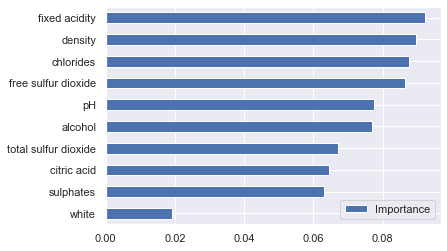

In [51]:
plot_variable_importance( x , y )

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели

In [53]:
model_params  = {
    "svm" : {
        "model":SVC(gamma="auto"),
        "params":{
            'C' : [1,10,20],
            'kernel':["rbf"]
        }
    },
    
    "decision_tree":{
        "model": DecisionTreeClassifier(),
        "params":{
            'criterion':["entropy","gini"],
            "max_depth":[5,8,9]
        }
    },
    
    "random_forest":{
        "model": RandomForestClassifier(),
        "params":{
            "n_estimators":[1,5,10],
            "max_depth":[5,8,9]
        }
    },
    "naive_bayes":{
        "model": GaussianNB(),
        "params":{}
    },
    
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear',multi_class = 'auto'),
        'params': {
            "C" : [1,5,10]
        }
    }
    
}

In [54]:
score=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=8,return_train_score=False)
    clf.fit(x,y)
    score.append({
        "Model" : model_name,
        "Best_Score": clf.best_score_,
        "Best_Params": clf.best_params_
    })

In [55]:
df5 = pd.DataFrame(score,columns=["Model","Best_Score","Best_Params"])

In [56]:
df5

,Model,Best_Score,Best_Params
0,svm,0.932193,"{'C': 1, 'kernel': 'rbf'}"
1,decision_tree,0.923172,"{'criterion': 'entropy', 'max_depth': 5}"
2,random_forest,0.932349,"{'max_depth': 5, 'n_estimators': 10}"
3,naive_bayes,0.636770,{}
4,logistic_regression,0.932348,{'C': 1}


In [57]:

clf_svm = SVC(kernel="rbf",C=1)
scores = cross_val_score(clf_svm,x,y,cv=8,scoring="accuracy")

In [58]:
scores

array([0.93283582, 0.93283582, 0.93283582, 0.93283582, 0.93283582,
       0.93159204, 0.93275218, 0.93275218])

In [59]:
scores.mean()

0.9326594378667064

## 4.2 Обучение модели

In [60]:
clf_svm1 = SVC(kernel="rbf",C=1)
clf_svm1.fit(x_train,y_train)

SVC(C=1)

In [61]:
y_pred = clf_svm1.predict(x_test)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [62]:
accuracy = accuracy_score(y_test,y_pred)

In [63]:
accuracy

0.9339035769828927

In [64]:
accuracy_dataframe = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

In [65]:
accuracy_dataframe.head()

,y_test,y_pred
1935,1,1
1106,2,1
2932,1,1
743,1,1
2230,1,1


# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [72]:
test_Y = clf_svm1.predict( x_test )
wine_idx = x_test.index
test = pd.DataFrame( { 'Wine_idx': wine_idx , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'wine_q_pred.csv' , index = False )